In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

#libraries
import pandas as pd
import numpy as np
from datetime import date

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
#Visual format
pd.options.display.float_format = '{:20,.4f}'.format

#my libraries
from wrangle import get_zillow_data, wrangle_zillow, remove_outliers, train_validate_test_split, get_hist, get_box, summarize
from explore import inertia, variable_distributions, plot_against_target
import evaluate
import model
import env

#library imports
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve

# Statistical Tests
import scipy.stats as stats

#alpha
alpha = .05

# Executive Summary

- Continuing with the Zillow 2017 properties and predictions for single unit family homes I am looking for what is driving the errors in the Zestimates.

- Of the five tested features against, log error is dependent of age, sqft and home value.

- Through exploration and statistical testing I found homes over 50, homes with less than 1000 sqft, and homes values less than 250,000 are the biggest drivers of errors.

- In feature engineering my model did do better then the baseline; however, modeling on sqft my data with a baseline of 0.165 my test data came back with an RMSE of 0.175.

- What I would like to test is exactly where the highest amount of the homes are located.



## Plan

- My plan is to take the 2017 properties and predictions through the data pipeline in order to find log error drivers and prepare a model to predict future errors.

- Select the <a href="https://trello.com/invite/b/EMEzPn69/2f064c89555d288b2b4b55618ceaceab/clusteringproject">link</a> to find a copy of my trello board I used in planning and executing this project.

- Objectives:
    - Is a higher log error dependent on homes over 50 years old? (Cluster - 2)
    - Is a higher log error dependent on homes less 1000 sqft? (Cluster - 6)
    - Is a higher log error dependent on homes who's ppsqft is less 200? (Cluster - 7)
    - Is a higher log error dependent on homes with a smaller lot size? (Cluster - 8)
    - Is a higher log error dependent on less expensive homes? (Cluster - 9)

## Acquired

- I acquired my data via the zillow SQL database, importing all tables (LEFT JOIN), sub query DISTINCT id from 2017 properties, WHERE statement for 2017% from the predictions table and where latitude iS NOT NULL.  

In [2]:
df = get_zillow_data()
df.head(2)

,parcelid,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,basementsqft,...,id,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,261.0000,NaN,NaN,NaN,NaN,1727539,NaN,...,0,0.0256,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,17052889,NaN,NaN,261.0000,NaN,NaN,NaN,NaN,1387261,NaN,...,1,0.0556,2017-01-01,None,None,None,None,Single Family Residential,None,None


In [3]:
summarize(df)

(77579, 69)
___________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77579 entries, 0 to 77578
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77579 non-null  int64  
 1   typeconstructiontypeid        223 non-null    float64
 2   storytypeid                   50 non-null     float64
 3   propertylandusetypeid         77579 non-null  float64
 4   heatingorsystemtypeid         49571 non-null  float64
 5   buildingclasstypeid           15 non-null     float64
 6   architecturalstyletypeid      207 non-null    float64
 7   airconditioningtypeid         25007 non-null  float64
 8   id                            77579 non-null  int64  
 9   basementsqft                  50 non-null     float64
 10  bathroomcnt                   77579 non-null  float64
 11  bedroomcnt                    77579 non-null  float64
 12  buildingqualitytypei

##### Key Takeaways
1. A total of 77579 rows and 69 columns.
2. I will need to rename columns for an easier read.
3. Find which columns/rows I will need to keep or drop.
4. There is a large number of missing values and I will need to figure out how to deal with those in the prepare section.
5. Convert data types as necessary.

## Prepared

In [4]:
df = wrangle_zillow(df)
df.head(2)

,bathrooms,bedrooms,sqft,county_code,latitude,longitude,lot_size,tax_value,logerror,county,age,tax_rate,price_per_sqft,abs_logerror
0,3,4,3100,6059,"33,634,931.0000","-117,869,207.0000",4506,1023282,0.0256,Orange,23,0.0108,330,0.0256
1,1,2,1465,6111,"34,449,266.0000","-119,281,531.0000",12647,464000,0.0556,Ventura,54,0.0122,316,0.0556


In [5]:
summarize(df)

(71359, 14)
___________________________
<class 'pandas.core.frame.DataFrame'>
Int64Index: 71359 entries, 0 to 77578
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bathrooms       71359 non-null  int64  
 1   bedrooms        71359 non-null  int64  
 2   sqft            71359 non-null  int64  
 3   county_code     71359 non-null  int64  
 4   latitude        71359 non-null  float64
 5   longitude       71359 non-null  float64
 6   lot_size        71359 non-null  int64  
 7   tax_value       71359 non-null  int64  
 8   logerror        71359 non-null  float64
 9   county          71359 non-null  object 
 10  age             71359 non-null  int64  
 11  tax_rate        71359 non-null  float64
 12  price_per_sqft  71359 non-null  int64  
 13  abs_logerror    71359 non-null  float64
dtypes: float64(5), int64(8), object(1)
memory usage: 8.2+ MB
None
___________________________
bathrooms         0
bedrooms        

##### Key Takeaways
1. Reduced total number of columns to 71359 and number of rows to 14.
2. Drop columns missing 70% of values.
3. Drop columns missing 50% of values.
4. Remain nulls were filled with the respective average.
5. Filtered all, but single use properties 'propertylandusetypeid'. A list of id's are annotated in the wrangle.py.
6. Filtered out homes having no bedrooms or baths.
7. Add a 'county' column with the county name using 'fips' codes. Kept 'fips' later renamed 'county_code' for explortion and clustering.
8. Dropped all unnecessary columns based on initial counts, visualizations and hypothesis. A list of dropped columns can be fo und in the wrangle.py.
9. Caluclated and added columns for home 'age', 'tax_rate', and 'price_per_sqft'.
10. Converted integers, left decimal numbers as floats and name of counties, 'county' as an object.
11. In my initial exploration of the raw data I removed any outliers below the 25 percentile and above 75 percentile.
12. The .describe below is a reflection of the clean data with all outliers remove.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,"71,359.0000",2.2019,0.9279,1.0000,2.0000,2.0000,3.0000,13.0000
bedrooms,"71,359.0000",3.0197,1.0044,1.0000,2.0000,3.0000,4.0000,11.0000
sqft,"71,359.0000","1,754.1957",929.5145,360.0000,"1,167.0000","1,514.0000","2,068.0000","21,929.0000"
county_code,"71,359.0000","6,049.2161",20.7240,"6,037.0000","6,037.0000","6,037.0000","6,059.0000","6,111.0000"
latitude,"71,359.0000","34,004,489.6257","269,699.7471","33,339,527.0000","33,804,158.0000","34,016,110.0000","34,176,039.5000","34,818,767.0000"
longitude,"71,359.0000","-118,194,442.2134","361,368.7181","-119,475,416.0000","-118,414,000.0000","-118,164,964.0000","-117,913,930.0000","-117,554,636.0000"
lot_size,"71,359.0000","30,533.2153","119,144.3694",236.0000,"6,000.0000","7,746.0000","24,038.0000","6,971,010.0000"
tax_value,"71,359.0000","488,789.2757","634,433.2677","1,000.0000","204,451.5000","357,143.0000","567,889.5000","25,381,250.0000"
logerror,"71,359.0000",0.0167,0.1671,-4.6554,-0.0236,0.0066,0.0383,5.2630
age,"71,359.0000",51.7106,23.1066,5.0000,34.0000,51.0000,67.0000,143.0000


### Split
- Here I am splitting my data into train, validate, and test for further exploration and modeling once the split data is scaled.

In [7]:
train, validate, test = train_validate_test_split(df)
print("train observations by shape: ", train.shape)
print("validate observations by shape: ", validate.shape)
print("test observations by shape: ", test.shape)

train observations by shape:  (39960, 14)
validate observations by shape:  (17127, 14)
test observations by shape:  (14272, 14)


## Explore

- I get a look at the train df to help determine which variables I'd like to take a look at using a histogram.
- I used .ticklabelformat to format the axis style. I used 'sci' as my style so the numbers use poower of tens foor readability.
- I'll view those variables and view them agains the target 'logerror' using .regplot.
- I used the same .tickplot_format as above for readability.
- 

##### Train variable distributions

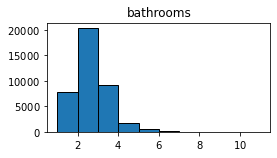

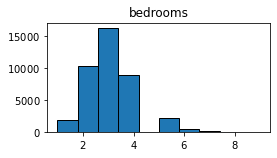

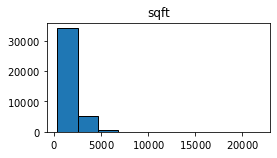

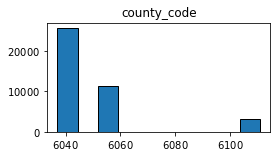

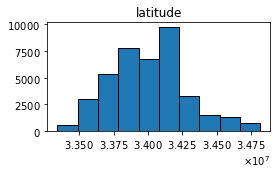

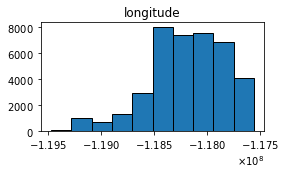

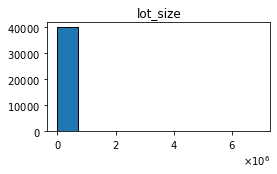

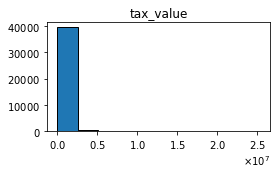

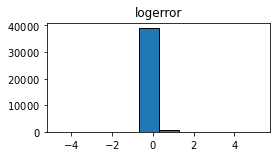

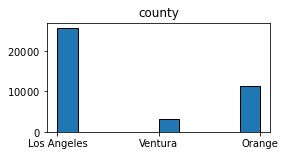

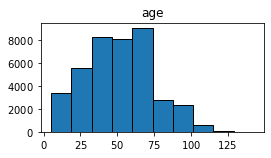

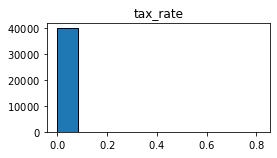

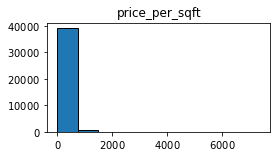

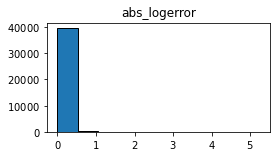

In [8]:
variable_distributions(train)

##### Key Takeaways
1. Majority of homes have 2-4 bathrooms.
2. Majority of homes are 2-4 bedrooms.
3. Majoprity of homes are < 2,500 sqft.
4. Homes are in three different counties with the majority of homes in 6040.
5. Majority of homes are < 75 years old.

##### Log error distributions

In [9]:
variables = ['bathrooms', 'bedrooms', 'sqft', 'latitude', 
            'longitude', 'lot_size', 'tax_value', 'age', 
            'tax_rate', 'price_per_sqft', 'county_code']

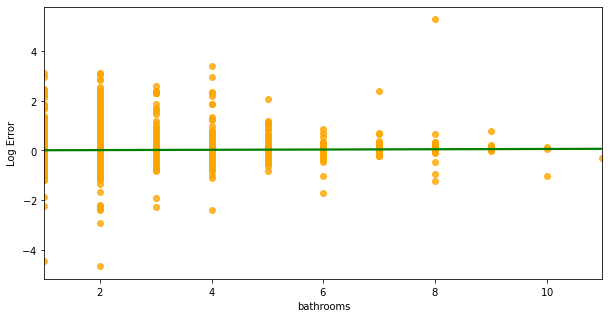

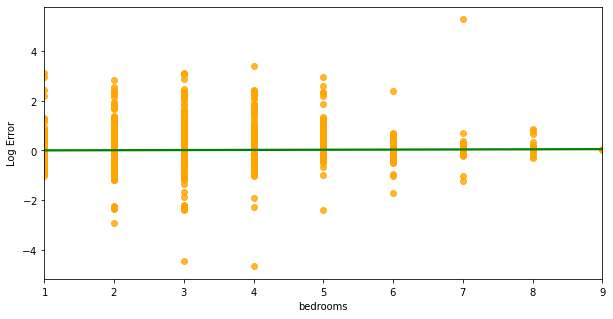

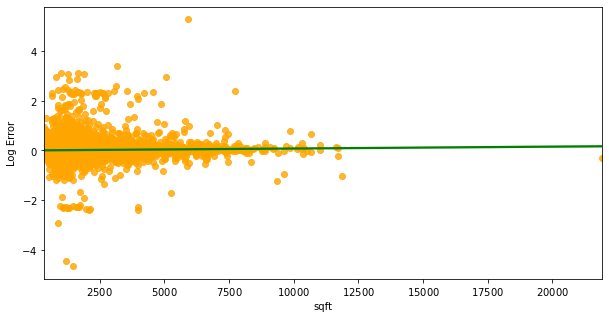

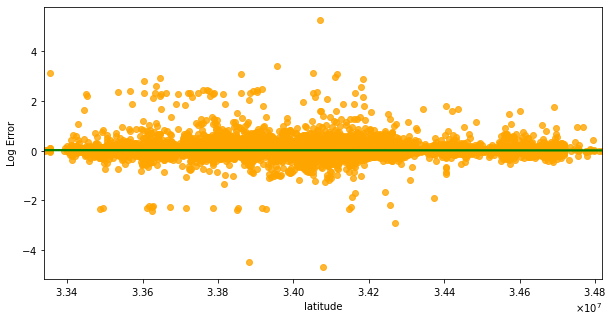

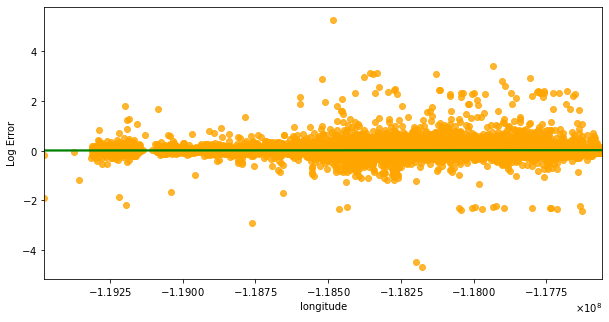

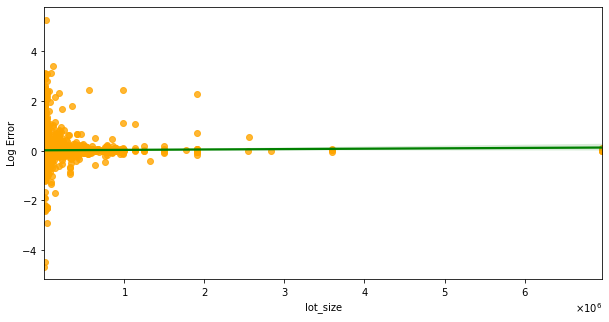

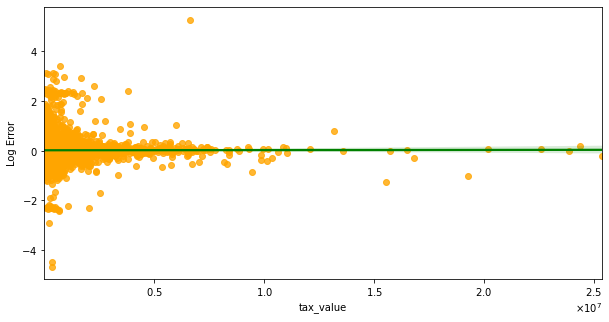

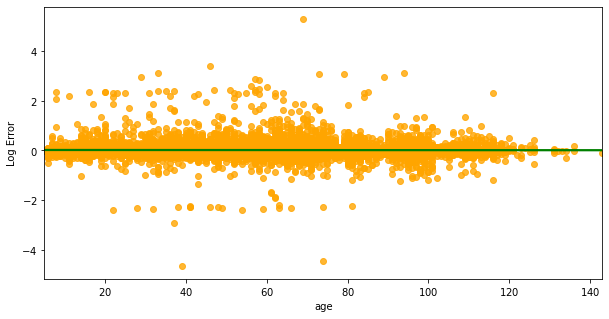

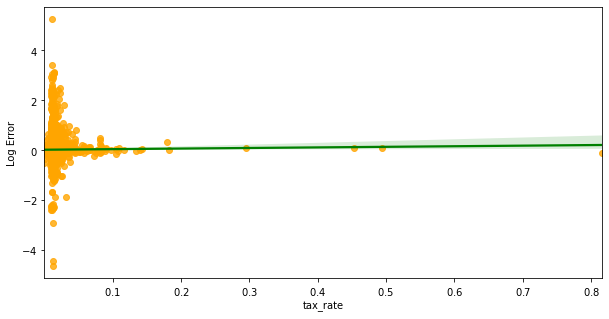

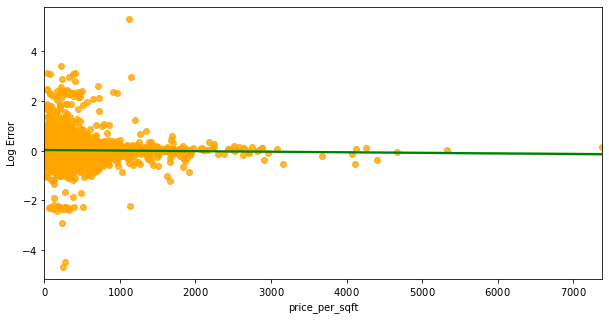

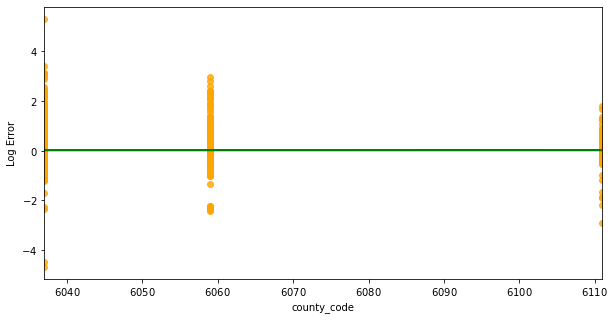

In [10]:
plot_against_target(train, target = 'logerror', var_list = variables)

<AxesSubplot:xlabel='county', ylabel='logerror'>

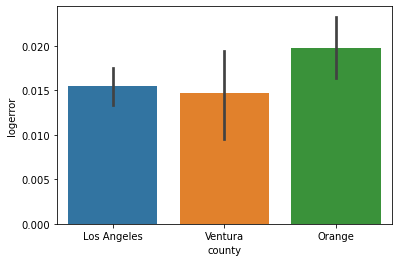

In [11]:
sns.barplot(x="county", y="logerror", data=train)

##### Key Takeaways
1. Higher error rate with homes <= 5 bathrooms.
2. Higher error rate with homes between 2-5 bedrooms.
3. Homes with a lower sqft have a higher error rate.
4. Homes with a lower lot size have a higher error rate.
5. Homes with a lower tax value have a higher error rate.
6. In this view age has a sligh error rate.
7. Homes with a lower tax rate have a higher error rate.
8. A lower price per sqft has a higher error rate.
9. Homes in Orange county have a higher error rate.

### Clustering
- I used my clustering as a preprocesing and exloratory step to help develop my hypothesis based on the information above.

#### Scale
- Here I scaled my data for clustering and modeling.

In [12]:
#empty copies to retain the original splits
train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()
#scale
scaler = MinMaxScaler()
#drop object column
cols = train.drop(columns=["county"]).columns.tolist()
#fit scaled data
train_scaled[cols] = scaler.fit_transform(train[cols])
validate_scaled[cols] = scaler.fit_transform(validate[cols])
test_scaled[cols] = scaler.fit_transform(test[cols])
#add object column back to the split dataframes
train_scaled["county"] = train.county.copy()
validate_scaled["county"] = validate.county.copy()
test_scaled["county"] = test.county.copy()

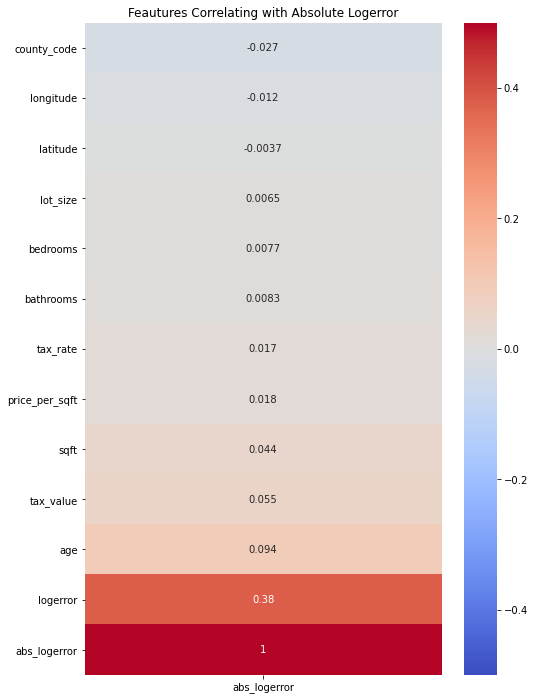

In [13]:
#create heatmap with scaled data
plt.figure(figsize=(8,12))
value_heatmap = sns.heatmap(train.corr()[['abs_logerror']].sort_values(by='abs_logerror', ascending=True), 
                            cmap='coolwarm', vmin=-.5, vmax=.5, annot=True)
value_heatmap.set_title('Feautures Correlating with Absolute Logerror')
plt.show()

##### Key Takeaways
1. The above heat map helped me confirm a few takeaways from the exploratory phase.
2. I will test age of home, its value, sqft, price per sqft and tax rate.

#### Cluster 1: Latitude and longitude clusters

In [14]:
X = train_scaled[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
train_scaled.groupby('cluster')['latitude', 'longitude'].mean()

,latitude,longitude
cluster,,
0,0.6554,0.4754
1,0.2346,0.8717
2,0.4354,0.6815


Text(0.5, 1.0, 'Visualizing Cluster Centers')

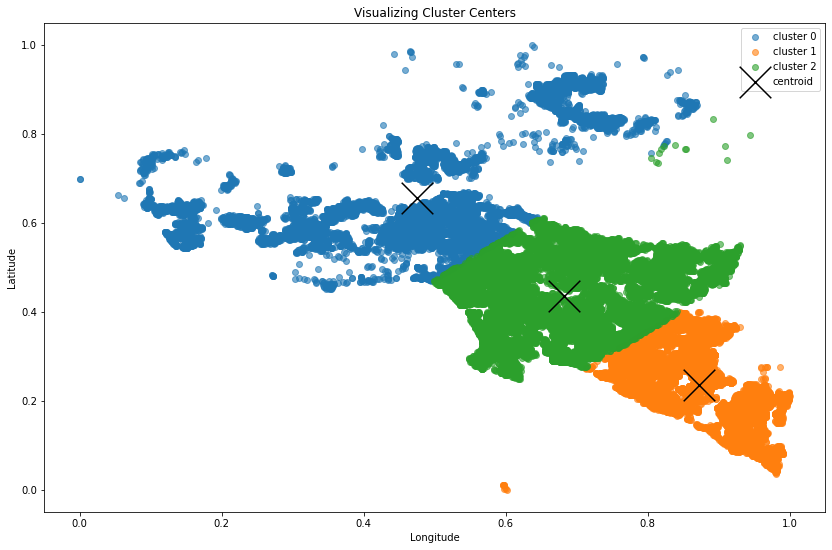

In [15]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.longitude, subset.latitude, label='cluster ' + str(cluster), alpha=.6)
centroids.plot.scatter(y='latitude', x='longitude', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualizing Cluster Centers')

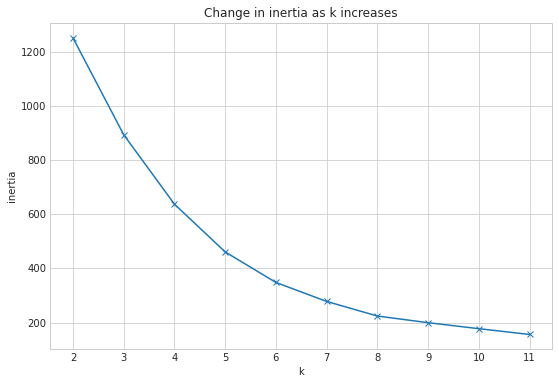

In [16]:
inertia(X)

##### Key Takeaways
1. Using the elbow method I think gowing with 3 or 4 clusters would be best. I choose to use three as it was a better representation of the counties. 
2. I would like to further incestigate this to get a better understanding of possible cities with a higher error rate.

#### Cluster 2: Log error to age of the home clusters

In [17]:
X = train_scaled[['logerror', 'age']]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
train_scaled.groupby('cluster')['logerror', 'age'].mean()

,logerror,age
cluster,,
0,0.4713,0.4061
1,0.4710,0.1801
2,0.4703,0.6323


Text(0.5, 1.0, 'Visualizing Cluster Centers')

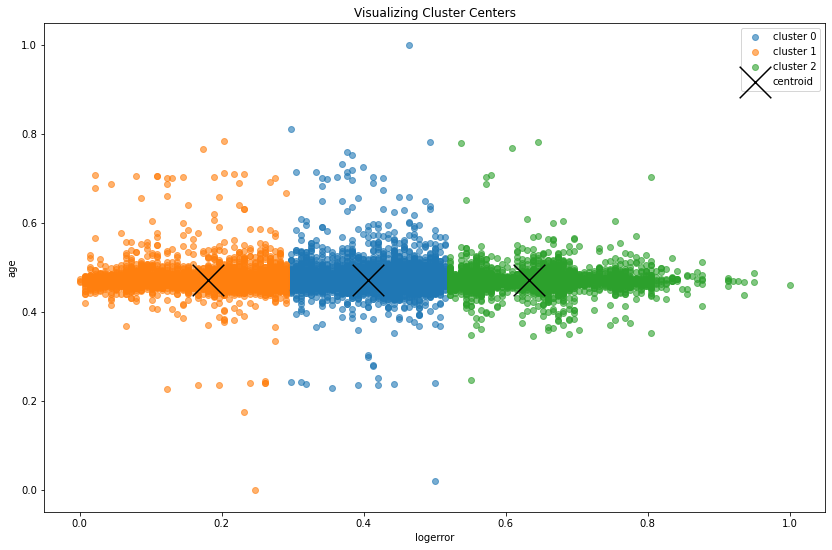

In [18]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.age, subset.logerror, label='cluster ' + str(cluster), alpha=.6)
centroids.plot.scatter(y='logerror', x='age', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('logerror')
plt.ylabel('age')
plt.title('Visualizing Cluster Centers')

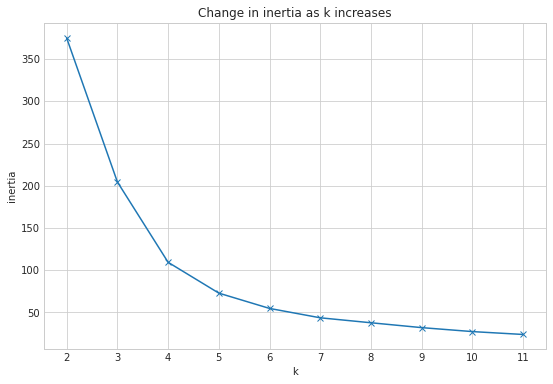

In [19]:
inertia(X)

##### Key Takeaways
1. Higer aged home tend to have a higher error rate.

#### Cluster 6: Log error to home square footage clusters

In [20]:
X = train_scaled[['logerror', 'sqft']]
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
train_scaled.groupby('cluster')['logerror', 'sqft'].mean()

,logerror,sqft
cluster,,
0,0.4704,0.0744
1,0.4701,0.0374
2,0.4714,0.1328
3,0.4751,0.2518
4,0.6254,0.0617


Text(0.5, 1.0, 'Visualizing Cluster Centers')

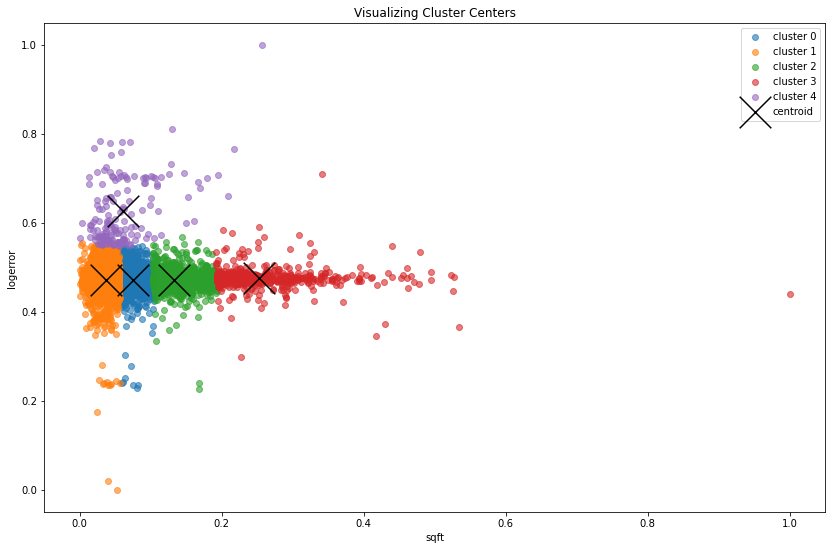

In [21]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.sqft, subset.logerror, label='cluster ' + str(cluster), alpha=.6)
centroids.plot.scatter(y='logerror', x='sqft', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('sqft')
plt.ylabel('logerror')
plt.title('Visualizing Cluster Centers')

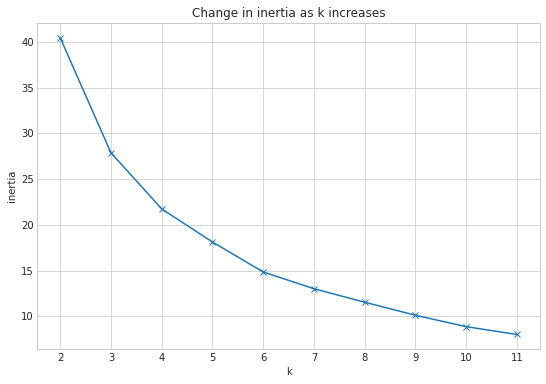

In [22]:
inertia(X)

##### Key Takeaways
1. Even though the elbow method may suggest using a n_cluster of three when I choose to run 4 cluster I became curious to that fourth cluster. Which then led my to include in my hypothesis for testing.

#### Cluster 7: Log error to price per square footage clusters

In [23]:
X = train_scaled[['logerror', 'price_per_sqft']]
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
train_scaled.groupby('cluster')['logerror', 'price_per_sqft'].mean()

,logerror,price_per_sqft
cluster,,
0,0.4697,0.0444
1,0.4708,0.0179
2,0.4666,0.2591
3,0.4691,0.0914
4,0.5889,0.0319


Text(0.5, 1.0, 'Visualizing Cluster Centers')

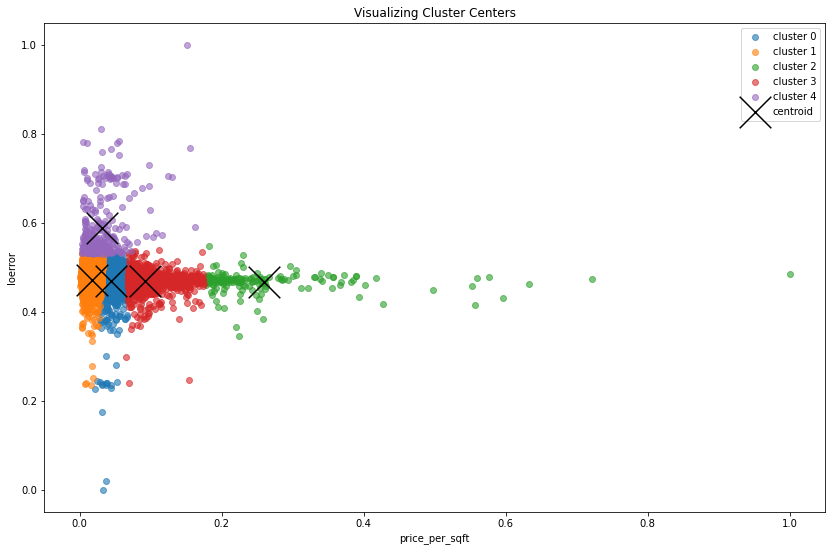

In [24]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.price_per_sqft, subset.logerror, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='logerror', x='price_per_sqft', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('price_per_sqft')
plt.ylabel('loerror')
plt.title('Visualizing Cluster Centers')

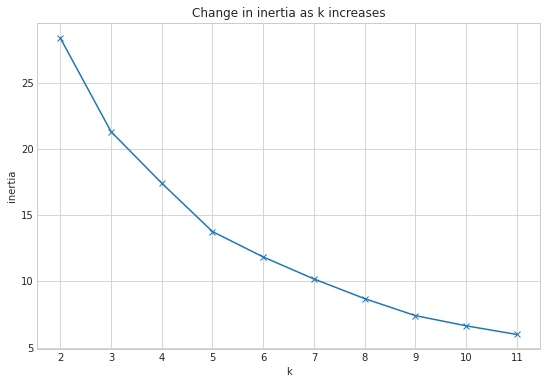

In [25]:
inertia(X)

##### Key Takeaways
1. Again here when I ran 5 clusters I saw the fifth clusters to which I have also include in my hypothesis testing.

#### Cluster 8: Log error to lot size clusters

In [26]:
X = train_scaled[['logerror', 'lot_size']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
train_scaled.groupby('cluster')['logerror', 'lot_size'].mean()

,logerror,lot_size
cluster,,
0,0.4701,0.0028
1,0.4709,0.7844
2,0.5825,0.0052
3,0.4702,0.0805


Text(0.5, 1.0, 'Visualizing Cluster Centers')

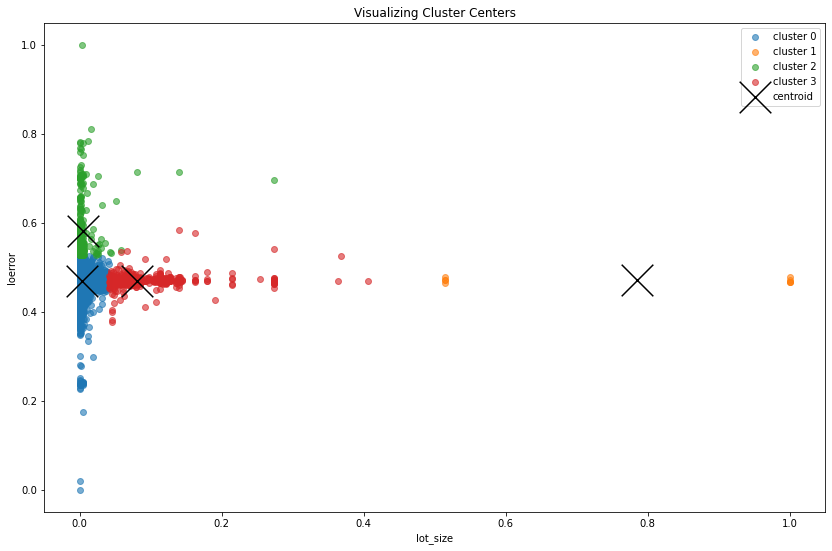

In [27]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.lot_size, subset.logerror, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='logerror', x='lot_size', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('lot_size')
plt.ylabel('loerror')
plt.title('Visualizing Cluster Centers')

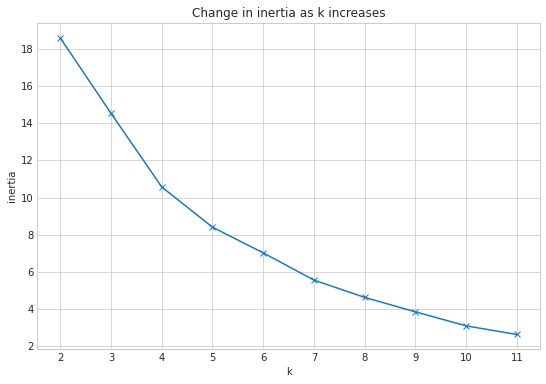

In [28]:
inertia(X)

##### Key Takeaway
1. I again decided to test this 4th cluster.

#### Cluster 9: Log error to home value clusters

In [29]:
X = train_scaled[['logerror', 'tax_value']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
train_scaled.groupby('cluster')['logerror', 'tax_value'].mean()

,logerror,tax_value
cluster,,
0,0.4701,0.0146
1,0.4678,0.3261
2,0.4710,0.0695
3,0.5885,0.0178


Text(0.5, 1.0, 'Visualizing Cluster Centers')

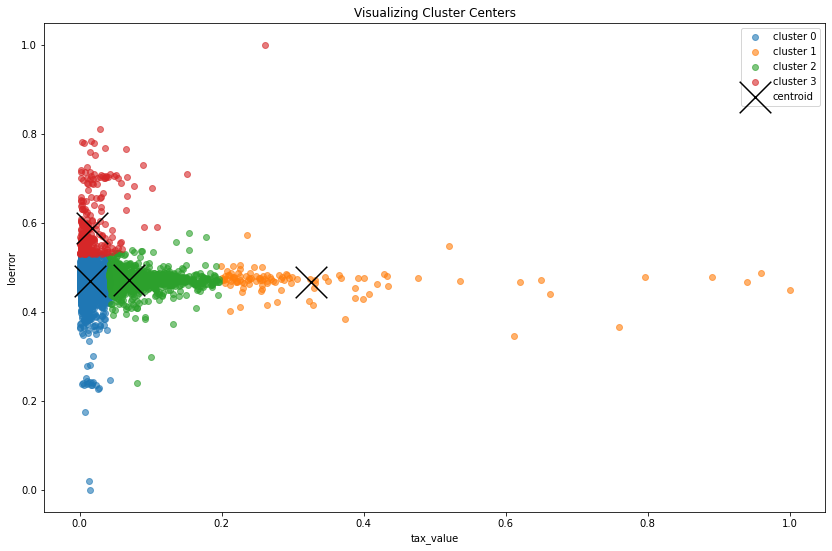

In [30]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.tax_value, subset.logerror, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='logerror', x='tax_value', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('tax_value')
plt.ylabel('loerror')
plt.title('Visualizing Cluster Centers')

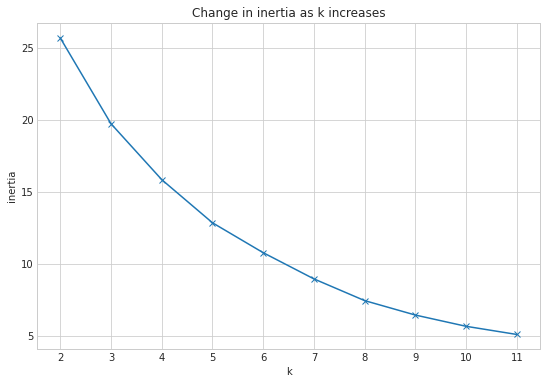

In [31]:
inertia(X)

##### Key Takeaways
1. Home value in exploration had a high error rate.
2. I decided to test the 4th cluster.

### Hypothesis derived from the explore phase
- Is a higher log error dependent on homes over 50 years old? (Cluster - 2)
- Is a higher log error dependent on homes less 1000 sqft? (Cluster - 6)
- Is a higher log error dependent on homes who's ppsqft is less 200? (Cluster - 7)
- Is a higher log error dependent on homes with a smaller lot size? (Cluster - 8)
- Is a higher log error dependent on less expensive homes? (Cluster - 9)

### Statistical Testing
- I'll be testing the above listed hypothesis using the chi2 method.

##### Is a higher log error dependent on homes over 50 years old? (Cluster - 2)

In [32]:
Null = 'Is independent'
Alternate = 'Is dependent'

observed = pd.crosstab(train.logerror > 0, train.age > 50)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 39.8021
p     = 0.0000


We reject the null and accept the alternate: Is dependent


##### Is a higher log error dependent on homes less 1000 sqft? (Cluster - 6)

In [33]:
Null = 'Is independent'
Alternate = 'Is dependent'

observed = pd.crosstab(train.logerror > 0, train.sqft > 1000)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 23.0525
p     = 0.0000


We reject the null and accept the alternate: Is dependent


##### Is a higher log error dependent on homes who's ppsqft is less 500? (Cluster - 7)

In [34]:
Null = 'Is independent'
Alternate = 'Is dependent'

observed = pd.crosstab(train.logerror > 0, train.price_per_sqft < 500)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 0.3654
p     = 0.5455


We fail to reject the null and accept the null: Is independent


##### Is a higher log error dependent on homes with a smaller lot size? (Cluster - 8)

In [35]:
Null = 'Is independent'
Alternate = 'Is dependent'

observed = pd.crosstab(train.logerror > 0, train.lot_size < 236)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 0.0000
p     = 1.0000


We fail to reject the null and accept the null: Is independent


##### Is a higher log error dependent on less expensive homes? (Cluster - 9)

In [36]:
Null = 'Is independent'
Alternate = 'Is dependent'

observed = pd.crosstab(train.logerror > 0, train.tax_value < 250000)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 6.3568
p     = 0.0117


We reject the null and accept the alternate: Is dependent


##### Key Takeaways
1. Homes older than 50 years old have a higher log error rate.
2. Homes less than 1000sqft have a higher log error rate.
3. Homes less than 250,000 have a higher log error rate.
4. All others failed to reject the null.

## Model

### Feature Engineering
- Based on exploration and testing I decided to model on the following features.

In [37]:
X_train = train_scaled[['age', 'bathrooms', 'bedrooms', 'sqft', 'price_per_sqft', 'lot_size', 'tax_value']]#features
y_train = train.logerror
X_validate = validate_scaled[['age', 'bathrooms', 'bedrooms', 'sqft', 'price_per_sqft', 'lot_size', 'tax_value']]#features
y_validate = validate.logerror
X_test = test_scaled[['age', 'bathrooms', 'bedrooms', 'sqft', 'price_per_sqft', 'lot_size', 'tax_value']]#features
y_test = test.logerror

In [38]:
evaluate.rfe(X_train,y_train,1)

Index(['sqft'], dtype='object')

In [39]:
evaluate.rfe(X_train,y_train,3)

Index(['sqft', 'price_per_sqft', 'lot_size'], dtype='object')

In [40]:
evaluate.select_kbest(X_train,y_train,1)

Index(['sqft'], dtype='object')

In [41]:
evaluate.select_kbest(X_train,y_train,3)

Index(['bathrooms', 'bedrooms', 'sqft'], dtype='object')

##### Key Takeaways
1. What is interesting here is age does not factor into any of the tests.
2. Sqft is the best feature.

### Regression Modeling

# Model on Sqft

In [42]:
#baseline function calculates baseline and adds columns to the dataframe
evaluate.get_baseline(train,train[['sqft']], train['logerror'])

,bathrooms,bedrooms,sqft,county_code,latitude,longitude,lot_size,tax_value,logerror,county,age,tax_rate,price_per_sqft,abs_logerror,yhat_baseline,yhat
35417,1,1,792,6037,"33,832,389.0000","-118,088,033.0000",10624,43391,0.0336,Los Angeles,84,0.0210,54,0.0336,0.0166,0.0094
75709,2,4,2060,6037,"33,770,099.0000","-118,103,594.0000",7693,496914,-0.0546,Los Angeles,60,0.0120,241,0.0546,0.0166,0.0189
48946,3,3,2750,6111,"34,176,273.0000","-119,221,020.0000",4121,1068000,0.0075,Ventura,40,0.0125,388,0.0075,0.0166,0.0241
3102,3,3,3412,6059,"33,630,925.0000","-117,647,902.0000",9375,850417,0.1842,Orange,42,0.0101,249,0.1842,0.0166,0.0290
4854,1,1,1013,6037,"33,765,600.0000","-118,182,000.0000",69327,310220,-0.1807,Los Angeles,29,0.0119,306,0.1807,0.0166,0.0111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31583,4,3,3324,6059,"33,900,985.0000","-117,887,039.0000",5800,709615,0.0279,Orange,23,0.0112,213,0.0279,0.0166,0.0284
24870,1,2,1217,6037,"33,882,916.0000","-118,198,985.0000",9323,187101,0.6165,Los Angeles,80,0.0149,153,0.6165,0.0166,0.0126
33566,2,3,2135,6059,"33,666,308.0000","-117,916,527.0000",6720,93341,0.0794,Orange,65,0.0167,43,0.0794,0.0166,0.0195
33858,2,2,1621,6037,"34,045,100.0000","-118,261,000.0000",83398,599719,-0.0043,Los Angeles,38,0.0124,369,0.0043,0.0166,0.0156


In [43]:
evaluate.get_residuals(train, train['logerror'])

,bathrooms,bedrooms,sqft,county_code,latitude,longitude,lot_size,tax_value,logerror,county,age,tax_rate,price_per_sqft,abs_logerror,yhat_baseline,yhat,residual,residual_baseline
35417,1,1,792,6037,"33,832,389.0000","-118,088,033.0000",10624,43391,0.0336,Los Angeles,84,0.0210,54,0.0336,0.0166,0.0094,-0.0241,-0.0170
75709,2,4,2060,6037,"33,770,099.0000","-118,103,594.0000",7693,496914,-0.0546,Los Angeles,60,0.0120,241,0.0546,0.0166,0.0189,0.0735,0.0712
48946,3,3,2750,6111,"34,176,273.0000","-119,221,020.0000",4121,1068000,0.0075,Ventura,40,0.0125,388,0.0075,0.0166,0.0241,0.0166,0.0091
3102,3,3,3412,6059,"33,630,925.0000","-117,647,902.0000",9375,850417,0.1842,Orange,42,0.0101,249,0.1842,0.0166,0.0290,-0.1551,-0.1676
4854,1,1,1013,6037,"33,765,600.0000","-118,182,000.0000",69327,310220,-0.1807,Los Angeles,29,0.0119,306,0.1807,0.0166,0.0111,0.1917,0.1973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31583,4,3,3324,6059,"33,900,985.0000","-117,887,039.0000",5800,709615,0.0279,Orange,23,0.0112,213,0.0279,0.0166,0.0284,0.0005,-0.0113
24870,1,2,1217,6037,"33,882,916.0000","-118,198,985.0000",9323,187101,0.6165,Los Angeles,80,0.0149,153,0.6165,0.0166,0.0126,-0.6039,-0.5999
33566,2,3,2135,6059,"33,666,308.0000","-117,916,527.0000",6720,93341,0.0794,Orange,65,0.0167,43,0.0794,0.0166,0.0195,-0.0600,-0.0628
33858,2,2,1621,6037,"34,045,100.0000","-118,261,000.0000",83398,599719,-0.0043,Los Angeles,38,0.0124,369,0.0043,0.0166,0.0156,0.0200,0.0209


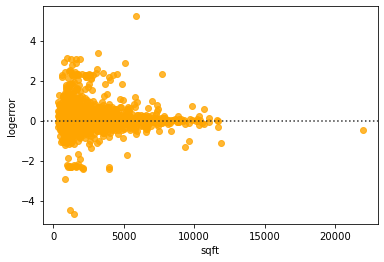

In [44]:
evaluate.plot_residual(train, train[['sqft']], train['logerror'])

In [45]:
evaluate.regression_errors(train, train['logerror'], train.yhat)

(0.027521622737870184,
 1099.7640446052926,
 1.8954852991705304,
 1101.6595299044632,
 0.1658964217150876)

In [46]:
evaluate.baseline_mean_errors(train, train['logerror'], train.yhat_baseline)

(0.027569057304916496, 1101.6595299044632, 0.1660393245737783)

In [47]:
evaluate.better_than_baseline(regression_errors = True, baseline_mean_errors = True)

The model is better then the baseline.


##### Key Takeaways
1. Modeling on sqft and log error the model did better then the baseline.

### Baseline Model

In [48]:
model.model_baseline(y_train, y_validate, 'logerror')

RMSE using Mean
Train/In-Sample:  0.17 
Validate/Out-of-Sample:  0.16
RMSE using Median
Train/In-Sample:  0.17 
Validate/Out-of-Sample:  0.16


#### Linear Regression

In [49]:
model.linear_regression(y_train, X_train, y_validate, X_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.16578663674172942 
Validation/Out-of-Sample:  0.1617184772404811


#### LassoLars

In [50]:
model.lassolars(y_train, X_train, y_validate, X_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.1660393245737783 
Validation/Out-of-Sample:  0.16192107522555363


#### Tpolynomial Regression

In [51]:
model.polynomialregression(y_train, X_train, y_validate, X_validate, X_test)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.165342362537843 
Validation/Out-of-Sample:  0.7393920899205655


##### Key Takeaways
1. Train RMSE on the Liner Regression model preformed better then the other two models.
2. With an RMSE of 0.1657 I chose to test on the liners regression model.

### Test

In [52]:
model.linear_regression_test(X_test, y_test)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.1753632721829155


##### Key Takeaways
- Test model did not perform as well as I hope going over by .100th of a point with an RMSE of 0.175 using sqft and logerror.

## Conclusion

- Used the 2017 properties dataset to derive features that are driving log errors in Zestimates.
- The best feature modeled is based on homes less than 1000 sqft.
- Although, home value was not featured in my rfe test, price_per_sqft was the second best feature.
- I modeled the best performing feature and tested the model with an RMSE of 0.175.